# Trade Sizing Techniques and Drawdown Control

This notebook aims to replicate some of the results in [Strub, I.S., *Trade Sizing Techniques For Drawdown And Tail Risk Control*, 2021](https://libertyroadcapital.com/2021/10/31/trade-sizing-techniques-for-drawdown-and-tail-risk-control/). Since some of the assumption have been left out in the paper, the replication will be incomplete and remains more of a proof of concept.

We use EURUSD as a sample asset with returns from 2003 to 2012 (which is what `yfinance` can offer...).

In [101]:
%matplotlib inline

import pickle

from arch.univariate import ARX, GARCH, StudentsT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
from tqdm import tqdm
import yfinance as yf

fx_pair = "EURUSD"
eurusd = yf.Ticker(f"{fx_pair}=X")
data = eurusd.history(start="2003-01-01", end="2012-12-31")
returns = data[["Close"]].apply(np.log).diff().dropna()

## Trade Strategy

We use simply Bollinger breakouts with an EWMA, i.e. long (short) if the close sits above the exponentially weighted moving average +/- 2 standard deviations. The decay factor $\lambda$ can be used in `pandas` as $\alpha=1-\lambda$ and we choose $0.94$ (see RiskMetrics).

**The performance of this strategy is obviously purely hypothetical and should only be used for illustration purposes**.

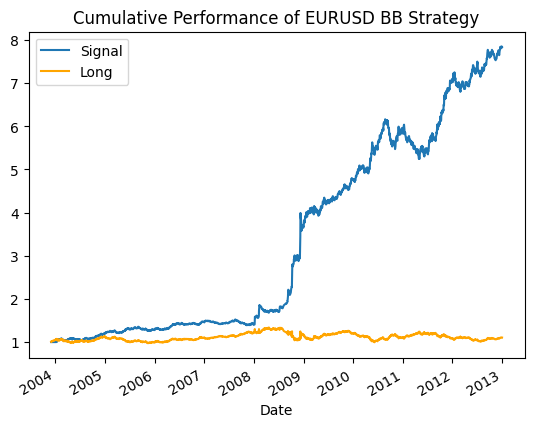

In [2]:
lambda_ = 0.94
alpha = 1 - lambda_
ewma = returns.ewm(alpha=alpha).mean()
std = returns.ewm(alpha=alpha).std()

# create signals and aggregate them
buy_signal = np.where(returns >= ewma + 2 * std, 1, 0)
sell_signal = np.where(returns <= ewma - 2 * std, -1, 0)
signals = pd.DataFrame({"Signal": buy_signal[:,0] + sell_signal[:,0]}, index=returns.index)
signals = signals.replace(0, np.nan).ffill().fillna(0)

# combine signals into strategy
strategy = returns * signals.values
fig, ax = plt.subplots()
strategy.cumsum().apply(np.exp).rename(columns={"Close":"Signal"}).plot(title="Cumulative Performance of EURUSD BB Strategy", legend=True, ax=ax)
returns.cumsum().apply(np.exp).rename(columns={"Close":"Long"}).plot(legend=True, color="orange", ax=ax);

The normal and historical 95% confidence level VaR are both super easy to compute. For the former we can approximate it as $VaR_n = -1.65\sigma$ and the latter is derived from the empirical distribution. Note that the value of $1.65$ results from the standard normal at the 95th confidence level (~z-score of 2). We can see the two values are in the same range, which gives us confidence that they are "correct".

Historical VaR: -0.0124, Normal VaR: -0.0150


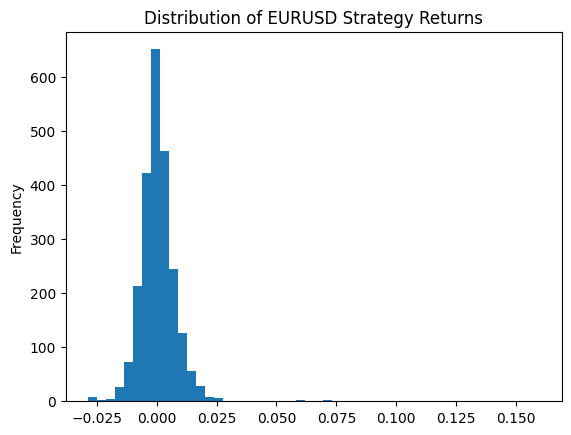

In [112]:
cl = 0.95
norm_var = scipy.stats.norm.ppf(cl) * strategy.std()[-1]
hist_var = np.quantile(strategy, cl)
print("Historical VaR: -{:.4f}, Normal VaR: -{:.4f}".format(hist_var, norm_var))
strategy.plot.hist(bins=50, legend=False, title="Distribution of EURUSD Strategy Returns");

## Fitting AR(1)-GARCH(1,1)

Following the paper, we fit an AR(1)-GARCH(1,1) model to the returns. The model is specified as follows:

$$r_t = \mu + a r_{t-1} + \epsilon_t \ \ \text{where: } \ \epsilon=z_t \sigma_t $$

Where:

$$\sigma_t^2 = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma_{t-1}^2 \ \ \text{with: } \ \alpha + \beta < 1$$

We assume the error term $z_t$ follows a Student T distribution. For now, we fit the distribution on the whole strategy. We can see all parameter are significant except for the AR(1) lag parameter $a$.

Note that in order to fit the model we need to scale the returns by 100. We will undo this at the end once the CVaR/VaR values have been calculated.

If we plot the ACF we should see that there is very low autocorrelation in the standard residuals (although not as perfect as in the paper) whereas the squared returns have significant lag 1 autocorrelation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                        Close   R-squared:                      -0.006
Mean Model:                              AR   Adj. R-squared:                 -0.006
Vol Model:                            GARCH   Log-Likelihood:               -2322.19
Distribution:      Standardized Student's t   AIC:                           4656.39
Method:                  Maximum Likelihood   BIC:                           4690.94
                                              No. Observations:                 2344
Date:                      Mon, Sep 19 2022   Df Residuals:                     2342
Time:                              22:45:51   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0244  1.180e-02      2.071  3.840e-02  [1.305e-03,4.756e-02]
Close[1]   -1.4633e-03  2.245e-02 -6.518e-02      0.948 [-4.547e-02,4.254e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.9681e-03  2.553e-03      2.730  6.337e-03 [1.965e-03,1.197e-02]
alpha[1]       0.0497  1.735e-02      2.862  4.204e-03 [1.566e-02,8.368e-02]
beta[1]        0.9366  1.693e-02     55.319      0.000     [  0.903,  0.970]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.3789      0.766      7.025  2.142e-12 [  3.878,  6.880]
========================================================================

Covariance estimator: robust
"""

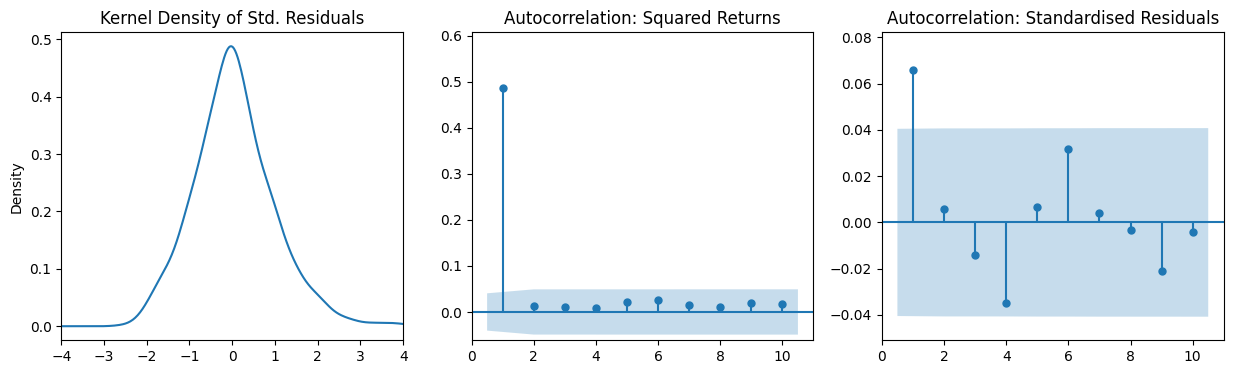

In [156]:
process = ARX(strategy.mul(100), lags=1, constant=True)
process.distribution = StudentsT()
process.volatility = GARCH(p=1, q=1)

fitted = process.fit(update_freq=0, disp="off")
std_residuals = fitted.resid / fitted.conditional_volatility
std_residuals = std_residuals[np.isfinite(std_residuals)]

# plot dist of std residuals and ACF
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=False)
pd.DataFrame({"Std Residuals": std_residuals}).plot(title="Kernel Density of Std. Residuals", kind="kde", xlim=(-4, 4), ax=ax[0], legend=False)
sm.graphics.tsa.plot_acf(strategy.apply(np.square), zero=False, lags=10, title="Autocorrelation: Squared Returns", ax=ax[1], auto_ylims=True)
sm.graphics.tsa.plot_acf(std_residuals, zero=False, lags=10, title="Autocorrelation: Standardised Residuals", ax=ax[2], auto_ylims=True)

fitted.summary()


## Bootstrap

Next we sample 252 times 10'000 standardised residuals with replacement in order to fit a GPD more accurately. The standard residuals have been obtained from our AR(1)-GARCH(1,1) model and can be calculated as $\epsilon \ / \sqrt{\sigma^2}$. You can clearly see the distribution is non-normal which shouldn't be surprising given the model specification. The Jarque Bera test statistic confirms this.

Note that there is some level of non-reproducability involved with this. Since `np.random.choice` doesn't allow you to fix the seed directly, you'd need to loop over the number of draws, setting the `np.random.seed` equal to some predefined but changing number.

Jarque-Bera statistic: 18073811.07


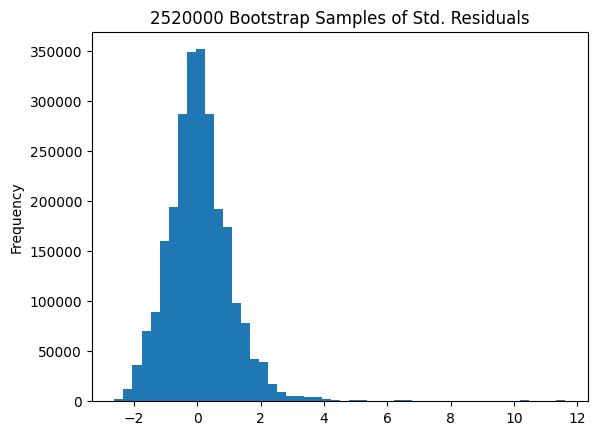

In [77]:
draws = 10000
n_obs = 252
bootstrap = [np.random.choice(std_residuals, n_obs) for i in range(draws)]
bootstrap = np.array(bootstrap).flatten()
pd.DataFrame(bootstrap).plot.hist(bins=50, title=f"{draws * n_obs} Bootstrap Samples of Std. Residuals", legend=False);
print("Jarque-Bera statistic: {:.2f}".format(scipy.stats.jarque_bera(bootstrap)[0]))

We can now fit a Generalised Pareto Distribution to the left tail of the distribution. The GPD is parameterised as:

$$F_{\xi}(z) = \begin{cases}
1 - \left(1 + \frac{\xi z}{\beta}\right)^{-1/\xi} & \text{for }\xi \neq 0, \\
1 - e^{-z /\beta} & \text{for }\xi = 0.
\end{cases}
$$

Where $\xi$ is a *shape* parameter and $\beta$ scale.

In [62]:
negative_returns = -1 * bootstrap[bootstrap < 0]
threshold = np.quantile(negative_returns, 1 - cl)
excess_returns = negative_returns[negative_returns >= threshold]

shape, loc, scale = scipy.stats.genpareto.fit(excess_returns, loc=0, scale=1)

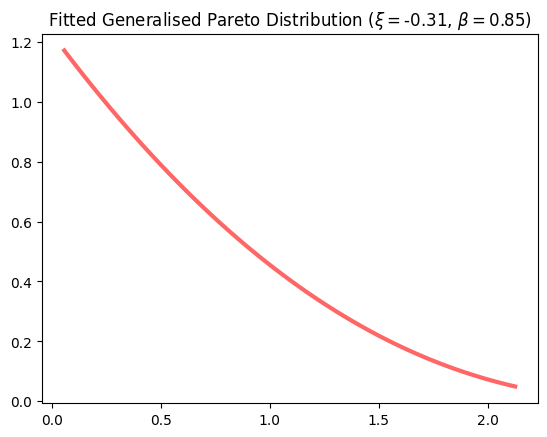

In [64]:
fig, ax = plt.subplots()
lower_bound = scipy.stats.genpareto.ppf(0.01, c=shape, loc=loc, scale=scale)
upper_bound = scipy.stats.genpareto.ppf(0.99, c=shape, loc=loc, scale=scale)
x = np.linspace(lower_bound, upper_bound, 100)
ax.plot(x, scipy.stats.genpareto.pdf(x, c=shape, loc=loc, scale=scale), 'r-', lw=3, alpha=0.6)
plt.title(r"Fitted Generalised Pareto Distribution ($\xi=${:.2f}, $\beta=${:.2f})".format(shape, scale));

## Calculate the EVT VaR and CVaR (Expected Shortfall)

Following the paper we define the EVT VaR as:

$$VaR_{EVT} = u + \frac{\beta}{\xi} \left(\left(\frac{\alpha N}{N_u}\right)^{-\xi}-1\right)$$

and consequently the CVaR:

$$CVaR_{EVT} = \frac{VaR_{EVT} + \beta - \xi u}{1-\xi}$$

Here, $N$ is the sample size of our bootstrap and $N_u$ the number of observations in the tail.

The results that we get are intuitive: both EVT VaR and CVaR are larger (i.e. worse) than the normal and historical VaR.

In [65]:
def evt_risk(xi: float, beta: float, u: float, n: int, n_u: int) -> tuple:
    """Implement VaR/CVaR as in Strub (2021)."""
    var = u + beta / xi * (np.power(alpha * n / n_u, -xi) - 1)
    cvar = (var + beta - xi * u) / (1 - xi)
    return var, cvar

In [66]:
evt_var, evt_cvar = evt_risk(shape, scale, threshold, bootstrap.shape[0], excess_returns.shape[0])
print("EVT VaR -{:.4f}, EVT CVaR: -{:.4f}".format(evt_var / 100, evt_cvar / 100))

EVT VaR -0.0135, EVT CVaR: -0.0169


## Trade Sizing
Now that we have the broad algorithm down, we can apply this to out strategy: We rebalance weekly by using 1 years worth of strategy returns (in a live setting this would initialise include backtested results). The portfolio weights are calculated as $w_t = 1 / VaR_{EVT} \times s_t$ where $s_t$ is our indicator signal for a long or short position. This is analogous to simplified volatility targeting.

In fact, the author states that a leverage factor is determined as:

$$\text{Leverage Factor} = \frac{\text{Target VaR}}{\text{Current VaR}}$$

The author sets the VaR target to 1.5% but this is really an arbitrary parameter depending on the strategy and risk aversion. 

One thing that wasn't clear to me is the following statement from Strub:
> From the shape and scale parameters of the ﬁtted GPD distribution a 95% CVaR is obtained and then converted into a 95% VaR using Equation (3). This ensures that the actual CVaR of the strategy is adjusted to match the CVaR corresponding to our target VaR level of 1.5% if the distribution was following a normal distribution.

Equation 3 simply states that VaR (CVaR) under a normal distribution is equal to 1.65 (2.07) times the standard deviation minus the mean. Perhaps this simply means we should rescale the CVaR by 0.83 (=1.67/2.07) to obtain a VaR equivalent? It seems odd to me though since we have closed for solutions for both under the GPD.

Finally, note that the below implementation is *slow* and will take around 1 to 2 hours to complete.

In [157]:
lookback = 252
results = {}

for date, _ in tqdm(strategy.iloc[lookback:,:].groupby(pd.Grouper(freq="W-FRI"))):
    sample = strategy[strategy.index <= date].iloc[-lookback:,:]
    ref_date = sample.index[-1]
    
    # step 1
    process = ARX(sample.mul(100), lags=1, constant=True)
    process.distribution = StudentsT()
    process.volatility = GARCH(p=1, q=1)

    fitted = process.fit(update_freq=0, disp="off")
    std_residuals = fitted.resid / fitted.conditional_volatility
    std_residuals = std_residuals[np.isfinite(std_residuals)]

    # step 2
    bootstrap = [np.random.choice(std_residuals, n_obs) for _ in range(draws)]
    bootstrap = np.array(bootstrap).flatten()
    
    # step 3
    negative_returns = -1 * bootstrap[bootstrap < 0]
    threshold = np.quantile(negative_returns, 1 - cl)
    excess_returns = negative_returns[negative_returns >= threshold]

    shape, loc, scale = scipy.stats.genpareto.fit(excess_returns)
    
    # step 4
    evt_var, evt_cvar = evt_risk(shape, scale, threshold, bootstrap.shape[0], excess_returns.shape[0])

    results[ref_date] = {
        "shape": shape,
        "loc": loc,
        "scale": scale,
        "var": evt_var,
        "cvar": evt_cvar,
        "threshold": threshold
    }

# save output to pickle
with open(f"data/{fx_pair}_evt_results.pk", "wb") as file:
    pickle.dump(results, file)

100%|██████████| 425/425 [1:53:15<00:00, 15.99s/it]


The final part is calculating the leverage factor and strategy returns. The leverage factor on my side doesn't resemble the one in the paper too much. Yet the results are sensible, i.e. they hover between 0.8 to 1.6.

Calculating the overall cumulative returns, we observe that the EVT based strategy outperforms the basic strategy in our artificial setting on a total return but not risk-adjusted basis. The maximum drawdown is slightly lower however, i.e. 15% for the original and 14% for the EVT strategy.

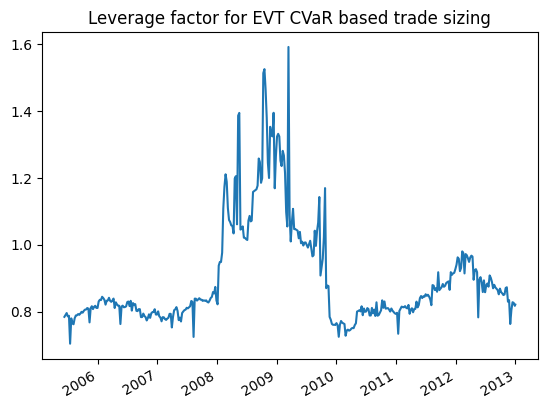

In [158]:
evt_df = pd.DataFrame.from_dict(results).T
var_target = 0.015
lvg_factor = var_target / (evt_df["cvar"] / 100)
lvg_factor.iloc[29:].plot(title="Leverage factor for EVT CVaR based trade sizing");

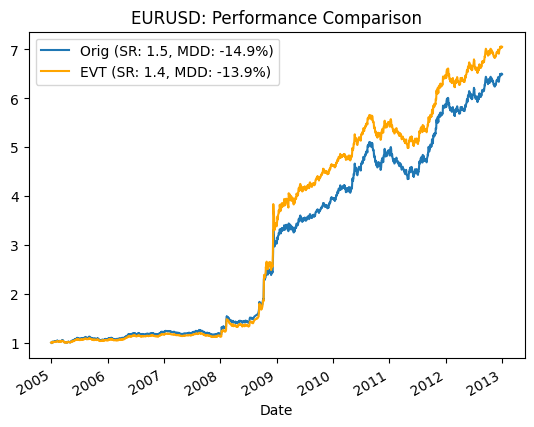

In [159]:
strategy_combined = strategy.join(lvg_factor.rename("LF")).ffill().dropna().iloc[29:]
orig_tr = strategy_combined["Close"].cumsum().apply(np.exp)
orig_sharpe = strategy_combined["Close"].mean() / strategy_combined["Close"].std() * np.sqrt(252)
orig_maxdd = orig_tr.div(orig_tr.cummax()).sub(1).min()

evt_strat = strategy_combined["Close"].mul(strategy_combined["LF"])
evt_tr = evt_strat.cumsum().apply(np.exp)
evt_sharpe = evt_strat.mean() / evt_strat.std() * np.sqrt(252)
evt_maxdd = evt_tr.div(evt_tr.cummax()).sub(1).min()

orig_tr.rename("Orig (SR: {:.1f}, MDD: {:.1%})".format(orig_sharpe, orig_maxdd)).plot(title=f"{fx_pair}: Performance Comparison", legend=True)
evt_tr.rename("EVT (SR: {:.1f}, MDD: {:.1%})".format(evt_sharpe, evt_maxdd)).plot(color="orange", legend=True);